# Обработка данных и запись в файлы для обучения моделей

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets
import seaborn as sn
import math
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn. metrics import mean_absolute_error as mae
from sklearn. metrics import mean_squared_error as mse
from sklearn. metrics import mean_squared_log_error as msqe
#from sklearn.metrics import mean_absolut_error

In [2]:
d_t = 0.01 #шаг по время
d_w = 0.01 #шаг окна
S_w_f = [lambda d: d[:,0].mean(), lambda d: d[:,0].mean()] #

In [3]:
#устанавливаем количество лагов [1, 4, 8, 12]
n = 12

In [4]:
#разбиваем файл на два(x и y) и находим начальное и последнее моменты времени (y)
def t_t_f(df):
    time_to_failure_x = df.values[:-1, 0]
    time_to_failure_y = df.values[:-1, 1]
    t0 = time_to_failure_y[-1]
    t1 = time_to_failure_y[0]
    return(t0, t1, time_to_failure_x, time_to_failure_y)

In [5]:
#нахождение индексов в сетке min max, чтобы окно не выходило за пределы имеющихся данных
def max_min(t0, t1):
    #с верхнего края
    #смотрим максимальный индекс в сетке
    it_max = math.floor(t1 / d_t)
    #подбираем индекс, чтобы мы находились внутри окна
    while d_t * it_max + d_w > t1:
        it_max -= 1
    #с нижнего края
    it_min = math.ceil(t0 / d_t)
    while d_t * it_min - d_w < t0:
        it_min += 1

    return(it_max, it_min)

In [6]:
#Рассчитываем три статистики с помощью метода окон
def metrics(time_to_failure_y, time_to_failure_x, it_max, it_min):
    okno_time_to_failure = []
    sum_time_to_failure = []
    count_time_to_failure = []
    sum_count_time_to_failure = []
    i = 0
    sum = float(0.0)
    count = 0
    j = len(time_to_failure_y)
    b = 1
    #считаем мат ожидание
    for i in range(it_min, it_max+1):
        b = d_t*i

        while time_to_failure_y[j-1] <= b-d_t:
            j -= 1

        while time_to_failure_y[j-1] <= b:
            sum += time_to_failure_x[j-1]
            j-=1
            count += 1

        sum_time_to_failure.append(sum)
        sum = float(0.0)
        count_time_to_failure.append(count)
        count = 0

    for i in range(len(sum_time_to_failure)-1):
        okno_time_to_failure.append((sum_time_to_failure[i]+sum_time_to_failure[i+1])/(count_time_to_failure[i]+count_time_to_failure[i+1]))


    for i in range(len(count_time_to_failure)-1):
        sum_count_time_to_failure.append(count_time_to_failure[i]+count_time_to_failure[i+1])

    #подсчет значенией time_to_failure для окна
    okno_time_to_failure_y = []
    for i in range(it_min, it_max):
        okno_time_to_failure_y.append(i*d_t)

    #считаем дисперсию
    disp_sum_time_to_failure_1 = []
    disp_sum_time_to_failure_2 = []
    disp_okno_time_to_failure = []
    disp_sum_1 = 0
    disp_sum_2 = 0
    j = len(time_to_failure_x)
    b = 1
    k = len(time_to_failure_x)
    for i in range(it_min, it_max+1):
        b = d_t*i

        while time_to_failure_y[j-1] <= b-d_t:
            j -= 1

        while time_to_failure_y[j-1] <= b:
            if i < it_max:
                disp_sum_time_to_failure_1.append((time_to_failure_x[j-1] - okno_time_to_failure[i-it_min])**2)
            if i > it_min:
                disp_sum_time_to_failure_2.append((time_to_failure_x[j-1] - okno_time_to_failure[i-it_min-1])**2)
            j-=1

    for i in range(len(count_time_to_failure)-1):
        disp_okno_time_to_failure.append((disp_sum_time_to_failure_1[i] + disp_sum_time_to_failure_2[i])/(sum_count_time_to_failure[i]-1))

### все остальное

    three_okno_time_to_failure = []
    sum = 0
    b = 1
    i = 1
    k = 0
    j = len(time_to_failure_y)

    for i in range(it_min, it_max):
        b = d_t*i

        if k == 0:

            while time_to_failure_y[j-1] <= b-d_t:
                j -= 1

            while time_to_failure_y[j-1] <= b:
                sum += ((time_to_failure_x[j-1] - time_to_failure_x[i - it_min])**2 + (time_to_failure_y[j-1] - time_to_failure_y[i - it_min])**2)**(0.5)
                j-=1
                k = 1
        else:

            while time_to_failure_y[j-1] <= b-d_t:
                j -= 1

            while time_to_failure_y[j-1] <= b:
                sum += ((time_to_failure_x[j-1] - time_to_failure_x[i - it_min])**2 + (time_to_failure_y[j-1] - time_to_failure_y[i - it_min])**2)**(0.5)
                j-=1

        three_okno_time_to_failure.append(sum)
        sum = 0
        if k == 1 :
            sum = float(0.0)
            k = 0

    return(okno_time_to_failure, disp_okno_time_to_failure, three_okno_time_to_failure, okno_time_to_failure_y)


In [7]:
#составляем таблицу для n*3 столбцов
def table_x_y_n(X, y, okno_time_to_failure, it_max, it_min, n):
    table = pd.DataFrame(index=range(it_min, it_max-n), columns=range(3*n), dtype='float64')
    for i in range(len(okno_time_to_failure)-n):
        for j in range(n):
            table[0+3*j].loc[table.index[i]] = X['среднее'].loc[X.index[i+j]]
            table[1+3*j].loc[table.index[i]] = X['дисперсия'].loc[X.index[i+j]]
            table[2+3*j].loc[table.index[i]] = X['расстояние'].loc[X.index[i+j]]


    #удаляем первые строки в у
    P = []
    for i in range(n):
        P.append(i)
    y_n = y.drop(index = P)

    return(table, y_n)

In [8]:
#функция для построения таблицы с лагами
def f_n(df, n):
    t_0, t_1, t_x, t_y = t_t_f(df)
    it_max, it_min = max_min(t_0, t_1)
    m_1, m_2, m_3, m_4 = metrics(t_y, t_x, it_max, it_min)
    X, y = table_x_y_n(m_1, m_2, m_3, m_4, it_max, it_min)
    X_n, y_n = table_x_y_n(X, y, m_1, it_max, it_min, n)

    return(X_n, y_n)

Обрабатываем данные и записываем в общие файлы соответсвенно количеству лагов

In [9]:
df_n_1 = pd.read_csv('1.csv.gz', delimiter=',')
#X_1_n, y_1_n = f_n(df_n_1, n)
#X_n_ = X_1_n
#y_n_ = y_1_n

In [10]:
df_n_2 = pd.read_csv('2.csv.gz', delimiter=',')
#X_2_n, y_2_n = f_n(df_n_2, n)
#X_n_ = X_n_.append(X_2_n,sort=False)
#y_n_ = y_n_.append(y_2_n,sort=False)

In [11]:
df_n_3 = pd.read_csv('3.csv.gz', delimiter=',')
#X_3_n, y_3_n = f_n(df_n_3, n)
#X_n_ = X_n_.append(X_3_n,sort=False)
#y_n_ = y_n_.append(y_3_n,sort=False)

In [12]:
df_n_4 = pd.read_csv('4.csv.gz', delimiter=',')
#X_4_n, y_4_n = f_n(df_n_4, n)
#X_n_ = X_n_.append(X_4_n,sort=False)
#y_n_ = y_n_.append(y_4_n,sort=False)

In [13]:
df_n_5 = pd.read_csv('5.csv.gz', delimiter=',')
#X_5_n, y_5_n = f_n(df_n_5, n)
#X_n_ = X_n_.append(X_5_n,sort=False)
#y_n_ = y_n_.append(y_5_n,sort=False)

In [14]:
df_n_6 = pd.read_csv('6.csv.gz', delimiter=',')
#X_6_n, y_6_n = f_n(df_n_6, n)
#X_n_ = X_n_.append(X_6_n,sort=False)
#y_n_ = y_n_.append(y_6_n,sort=False)

In [15]:
df_n_7 = pd.read_csv('7.csv.gz', delimiter=',')
#X_7_n, y_7_n = f_n(df_n_7, n)
#X_n_ = X_n_.append(X_7_n,sort=False)
#y_n_ = y_n_.append(y_7_n,sort=False)

In [16]:
df_n_8 = pd.read_csv('8.csv.gz', delimiter=',')
#X_8_n, y_8_n = f_n(df_n_8, n)
#X_n_ = X_n_.append(X_8_n,sort=False)
#y_n_ = y_n_.append(y_8_n,sort=False)

In [17]:
df_n_9 = pd.read_csv('9.csv.gz', delimiter=',')
#X_9_n, y_9_n = f_n(df_n_9, n)
#X_n_ = X_n_.append(X_9_n,sort=False)
#y_n_ = y_n_.append(y_9_n,sort=False)

In [18]:
df_n_10 = pd.read_csv('10.csv.gz', delimiter=',')
#X_10_n, y_10_n = f_n(df_n_10, n)
#X_n_ = X_n_.append(X_10_n,sort=False)
#y_n_ = y_n_.append(y_10_n,sort=False)

In [19]:
df_n_11 = pd.read_csv('11.csv.gz', delimiter=',')
#X_11_n, y_11_n = f_n(df_n_11, n)
#X_n_ = X_n_.append(X_11_n,sort=False)
#y_n_ = y_n_.append(y_11_n,sort=False)

In [20]:
df_n_12 = pd.read_csv('12.csv.gz', delimiter=',')
#X_12_n, y_12_n = f_n(df_n_12, n)
#X_n_ = X_n_.append(X_12_n,sort=False)
#y_n_ = y_n_.append(y_12_n,sort=False)

In [21]:
df_n_13 = pd.read_csv('13.csv.gz', delimiter=',')
#X_13_n, y_13_n = f_n(df_n_13, n)
#X_n_ = X_n_.append(X_13_n,sort=False)
#y_n_ = y_n_.append(y_13_n,sort=False)

In [22]:
df_n_14 = pd.read_csv('14.csv.gz', delimiter=',')
#X_14_n, y_14_n = f_n(df_n_14, n)
#X_n_ = X_n_.append(X_14_n,sort=False)
#y_n_ = y_n_.append(y_14_n,sort=False)

In [23]:
df_n_15 = pd.read_csv('15.csv.gz', delimiter=',')
#X_15_n, y_15_n = f_n(df_n_15, n)
#X_n_ = X_n_.append(X_15_n,sort=False)
#y_n_ = y_n_.append(y_15_n,sort=False)

In [24]:
df_n_16 = pd.read_csv('16.csv.gz', delimiter=',')
#X_16_n, y_16_n = f_n(df_n_16, n)
#X_n_ = X_n_.append(X_16_n,sort=False)
#y_n_ = y_n_.append(y_16_n,sort=False)

In [25]:
df_n_17 = pd.read_csv('17.csv.gz', delimiter=',')
#X_17_n, y_17_n = f_n(df_n_17, n)
#X_n_ = X_n_.append(X_17_n,sort=False)
#y_n_ = y_n_.append(y_17_n,sort=False)

In [26]:
#X_n_.to_csv('general_table_12_n.csv')
#y_n_.to_csv('general_table_target_12_n.csv')

In [27]:
#Соединим данные в одну 
dfs = [df_n_1, df_n_2, df_n_3, df_n_4, df_n_5, df_n_6, df_n_7, df_n_8, df_n_9, df_n_10, df_n_11, df_n_12, df_n_13, df_n_14, df_n_15, df_n_16, df_n_17]
merged_df = pd.concat(dfs, ignore_index=True)

In [28]:
# Среднее значения акустических данных по всем датасетам
t_x = merged_df['acoustic_data']
t_x.mean()

4.519467573700124

In [29]:
# Среднее значения времени по всем датасетам
t_y = merged_df['time_to_failure']
t_y.mean()

5.678291712978854

In [30]:
#приведем пример статистических значений временных данных первого эксперимента
t_y = df_n_2['time_to_failure']
t_y.describe()

count    4.442930e+07
mean     5.770726e+00
std      3.331640e+00
min      6.954822e-04
25%      2.885199e+00
50%      5.770698e+00
75%      8.656297e+00
max      1.154080e+01
Name: time_to_failure, dtype: float64

In [31]:
t_x = df_n_1['acoustic_data']
t_x.describe()

count    5.656574e+06
mean     4.560983e+00
std      2.342784e+01
min     -4.621000e+03
25%      2.000000e+00
50%      5.000000e+00
75%      7.000000e+00
max      3.252000e+03
Name: acoustic_data, dtype: float64

In [32]:
#Проверяем, как записались данные для 12 лагов
X_all_12_n = pd.read_csv('general_table_12_n.csv', delimiter=',')
y_all_12_n = pd.read_csv('general_table_target_12_n.csv', delimiter=',')


X_all_12_n = X_all_12_n.drop('Unnamed: 0', axis='columns')
y_all_12_n = y_all_12_n.drop('Unnamed: 0', axis='columns')
X_all_12_n

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,4.265972,0.000028,335510.183456,4.361681,0.000248,115723.624644,4.434416,0.000316,158960.291001,4.442023,...,382543.013653,4.258009,0.000200,114824.371426,4.208509,0.000002,142558.539806,4.367920,0.000008,136656.688920
1,4.361681,0.000248,115723.624644,4.434416,0.000316,158960.291001,4.442023,0.000522,114365.444648,4.405762,...,114824.371426,4.208509,0.000002,142558.539806,4.367920,0.000008,136656.688920,4.460051,0.000002,130974.567684
2,4.434416,0.000316,158960.291001,4.442023,0.000522,114365.444648,4.405762,0.000041,157898.206932,4.341707,...,142558.539806,4.367920,0.000008,136656.688920,4.460051,0.000002,130974.567684,4.423147,0.000014,125495.064647
3,4.442023,0.000522,114365.444648,4.405762,0.000041,157898.206932,4.341707,0.000117,181614.718668,4.222941,...,136656.688920,4.460051,0.000002,130974.567684,4.423147,0.000014,125495.064647,4.463906,0.000144,212107.247142
4,4.405762,0.000041,157898.206932,4.341707,0.000117,181614.718668,4.222941,0.000023,191449.407213,4.168521,...,130974.567684,4.423147,0.000014,125495.064647,4.463906,0.000144,212107.247142,4.439941,0.000186,117625.737727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16073,4.480867,0.000724,88983.601453,4.455374,0.000110,126495.824950,4.317713,0.000057,130859.580564,4.247481,...,84104.249081,4.147589,0.000084,184320.342172,4.257851,0.000415,110563.982422,4.410028,0.000159,156903.274808
16074,4.455374,0.000110,126495.824950,4.317713,0.000057,130859.580564,4.247481,0.000109,105653.872996,4.246291,...,184320.342172,4.257851,0.000415,110563.982422,4.410028,0.000159,156903.274808,4.480754,0.000061,93362.101380
16075,4.317713,0.000057,130859.580564,4.247481,0.000109,105653.872996,4.246291,0.000440,103866.809844,4.312474,...,110563.982422,4.410028,0.000159,156903.274808,4.480754,0.000061,93362.101380,4.389443,0.000238,149448.353708
16076,4.247481,0.000109,105653.872996,4.246291,0.000440,103866.809844,4.312474,0.000187,91286.610598,4.318398,...,156903.274808,4.480754,0.000061,93362.101380,4.389443,0.000238,149448.353708,4.262014,0.000031,187646.392134


# Построение моделей

#

In [33]:
#функция для построения графика обучения модели
def x_y(f, h):
    plt.figure(figsize=(7,7))
    plt.scatter(f, h)
    plt.axline((0,0),c = 'red', linestyle = '--',slope=1)
    plt.xlabel('Изначальный y', fontsize = 15)
    plt.ylabel('Предсказанный y',fontsize = 15)

    return()

In [34]:
#функция для построения графика зависимости количества лагов и ошибки
def F_n(f, h):
    x_new = np.linspace(min(f), max(f), 100)  # выбираем 100 точек между минимальным и максимальным значением f
    y_new = np.interp(x_new, f, h) # кубическая интерполяция значений h для новых точек x_new
    plt.figure(figsize=(7,7))
    plt.scatter(f, h)
    plt.plot(x_new, y_new, color='red', linewidth=2)
    #plt.axline((0,0),c = 'red', linestyle = '--',slope=1)
    plt.xlabel('Количество лагов', fontsize = 15)
    plt.ylabel('Ошибка',fontsize = 15)
    plt.show()

    return()

In [35]:
count_lag = [1, 4, 8, 12] #список с лагами
#Списки для каждой метрики. В них будем записывать значения метрик соответственно количеству лагов
reg_r2 = []
reg_mae = []
reg_mse = []
lasso_r2 = []
lasso_mae = []
lasso_mse = []
xgb_r2 = []
xgb_mae = []
xgb_mse = []
xgb_c_v = []

Линейная регрессия

In [36]:
def regression(a, b):
    X_train, X_test, y_train, y_test = train_test_split(a, b, test_size = 0.2, random_state=42)
    linear_regression_model = linear_model.LinearRegression()
    linear_regression_model.fit(X_train, y_train)
    test_predictions = linear_regression_model.predict(X_test)
    R2 = r2_score(y_test, test_predictions)
    mae_ = mae(y_test, test_predictions)
    mse_ = mse(y_test, test_predictions)
    return(y_test, test_predictions, R2, mae_, mse_)

0.2979295244360728 124.72429697049996 48819.16368071332


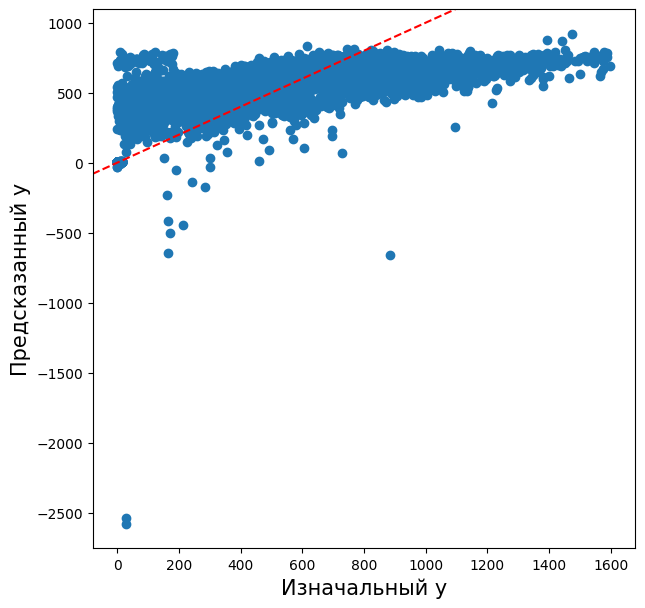

In [37]:
X_all_1_1 = pd.read_csv('general_table_1_1.csv', delimiter=',')
y_all_1_1 = pd.read_csv('general_table_target_1_1.csv', delimiter=',')
X_all_1_1 = X_all_1_1.drop( 'Unnamed: 0', axis='columns')

X_1, y_1, r_1, mae_1, mse_1 = regression(X_all_1_1, y_all_1_1)
x_y(X_1,y_1)
reg_r2.append(r_1)
reg_mae.append(mae_1)
reg_mse.append(mse_1)
print(r_1, mae_1, mse_1)


0.3598333488700473 121.40057603358622 44829.399024635866


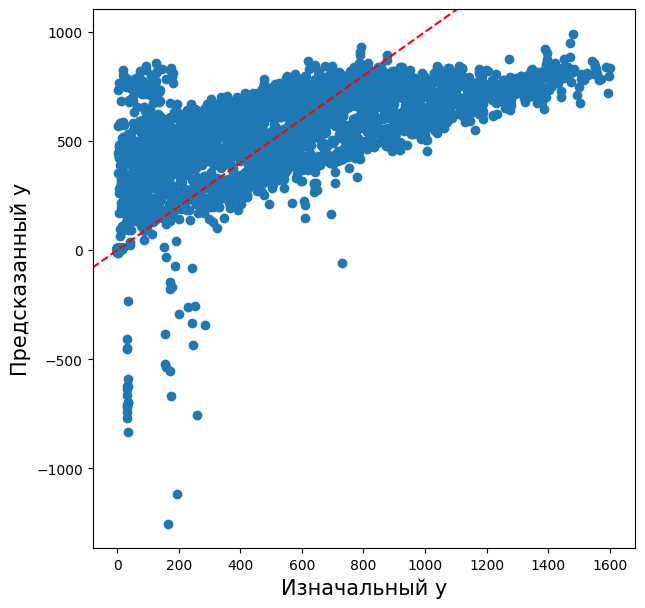

In [38]:
X_all_4_n = pd.read_csv('general_table_2_n.csv', delimiter=',')
y_all_4_n = pd.read_csv('general_table_target_2_n.csv', delimiter=',')
X_all_4_n = X_all_4_n.drop( 'Unnamed: 0', axis='columns')

X_2, y_2, r_2, mae_2, mse_2 = regression(X_all_4_n, y_all_4_n)
x_y(X_2,y_2)
reg_r2.append(r_2)
reg_mae.append(mae_2)
reg_mse.append(mse_2)
print(r_2, mae_2, mse_2)

0.3904163000265306 117.9034636350036 41817.94526818704


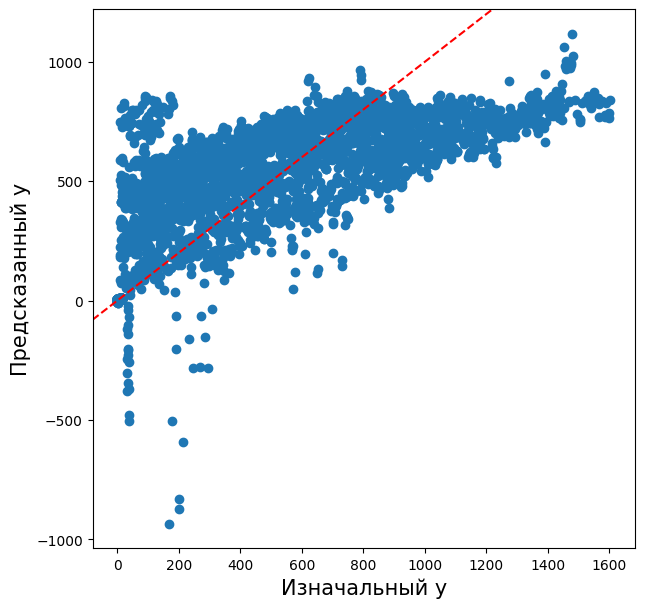

In [39]:
X_all_8_n = pd.read_csv('general_table_8_n.csv', delimiter=',')
y_all_8_n = pd.read_csv('general_table_target_8_n.csv', delimiter=',')
X_all_8_n = X_all_8_n.drop( 'Unnamed: 0', axis='columns')

X_3, y_3, r_3, mae_3, mse_3 = regression(X_all_8_n, y_all_8_n)
reg_r2.append(r_3)
reg_mae.append(mae_3)
reg_mse.append(mse_3)
x_y(X_3,y_3)
print(r_3, mae_3, mse_3)

0.41765000876533187 115.32358562445808 39679.98502849488


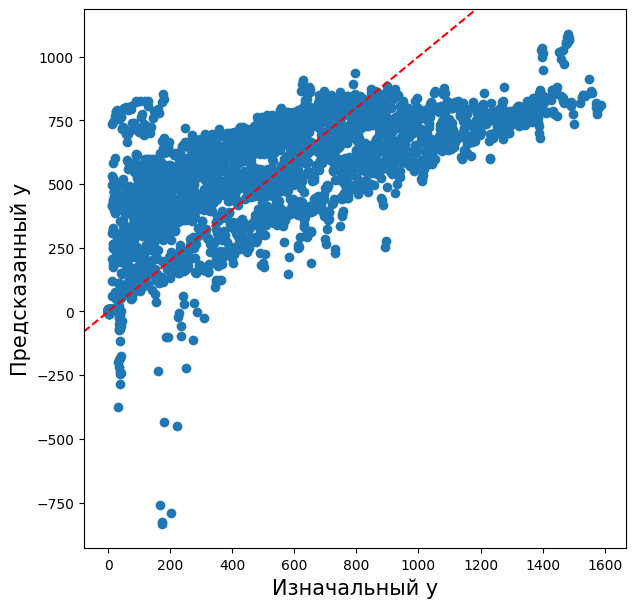

In [40]:
X_all_12_n = pd.read_csv('general_table_12_n.csv', delimiter=',')
y_all_12_n = pd.read_csv('general_table_target_12_n.csv', delimiter=',')
X_all_12_n = X_all_12_n.drop( 'Unnamed: 0', axis='columns')

X_4, y_4, r_4, mae_4, mse_4 = regression(X_all_12_n, y_all_12_n)
reg_r2.append(r_4)
reg_mae.append(mae_4)
reg_mse.append(mse_4)
x_y(X_4,y_4)
print(r_4, mae_4, mse_4)

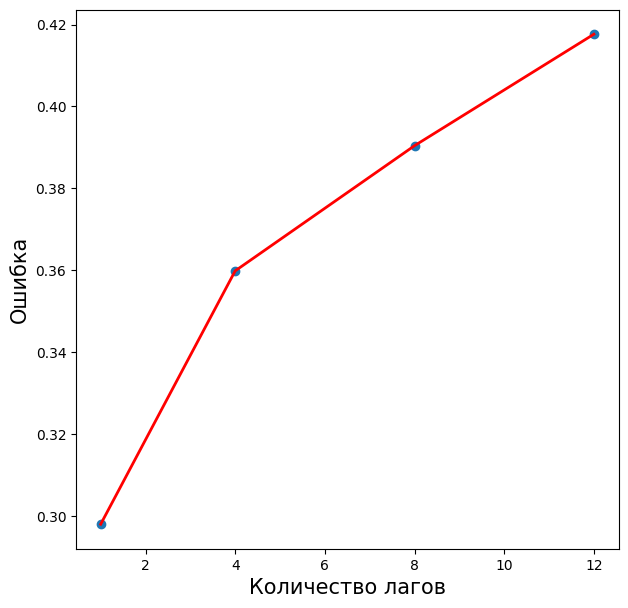

()

In [41]:
F_n(count_lag, reg_r2)

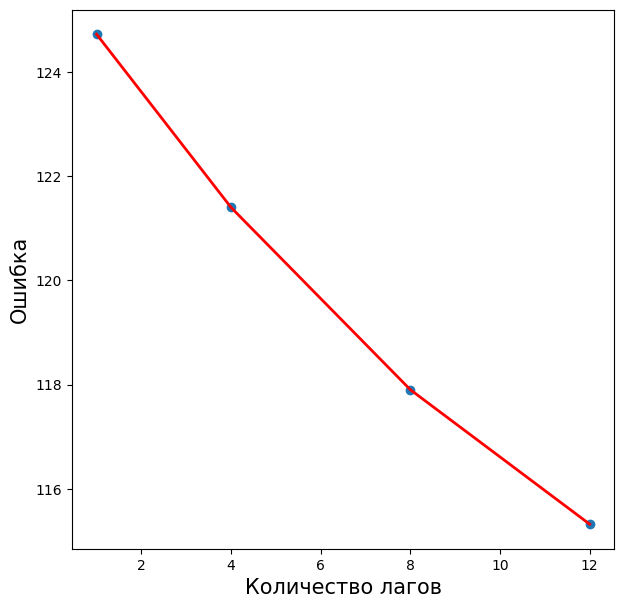

()

In [42]:
F_n(count_lag, reg_mae)

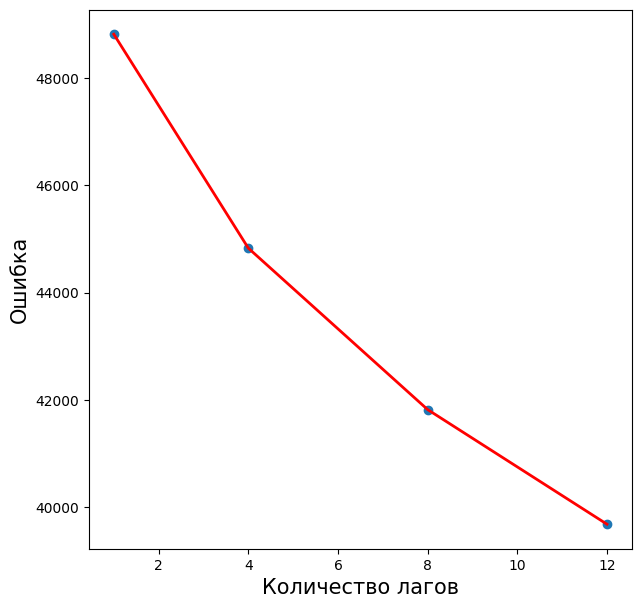

()

In [43]:
F_n(count_lag, reg_mse)

Лассо

In [44]:
def lasso(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
    clf = linear_model.Lasso(alpha=1)
    clf.fit(X_train, y_train)
    test_predictions = clf.predict(X_test)
    R2 = r2_score(y_test, test_predictions)
    mae_ = mae(y_test, test_predictions)
    mse_ = mse(y_test, test_predictions)
    return(y_test, test_predictions, R2, mae_, mse_)

0.29465304918737234 124.82107204084326 48924.13211887501


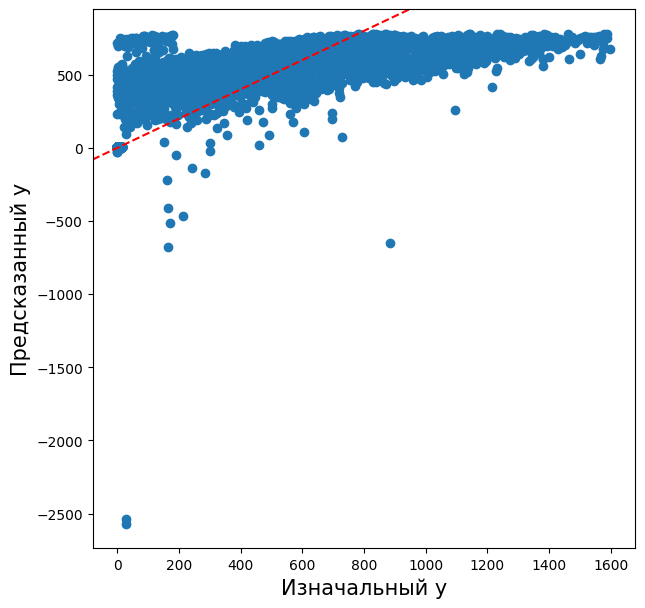

In [45]:
X_all_1_1 = pd.read_csv('general_table_1_1.csv', delimiter=',')
y_all_1_1 = pd.read_csv('general_table_target_1_1.csv', delimiter=',')
X_all_1_1 = X_all_1_1.drop( 'Unnamed: 0', axis='columns')

X_1, y_1, r_1, mae_1, mse_1 = lasso(X_all_1_1, y_all_1_1)
x_y(X_1,y_1)
lasso_r2.append(r_1)
lasso_mae.append(mae_1)
lasso_mse.append(mse_1)
print(r_1, mae_1, mse_1)

0.3543770303188656 121.5533565503731 45062.2427350323


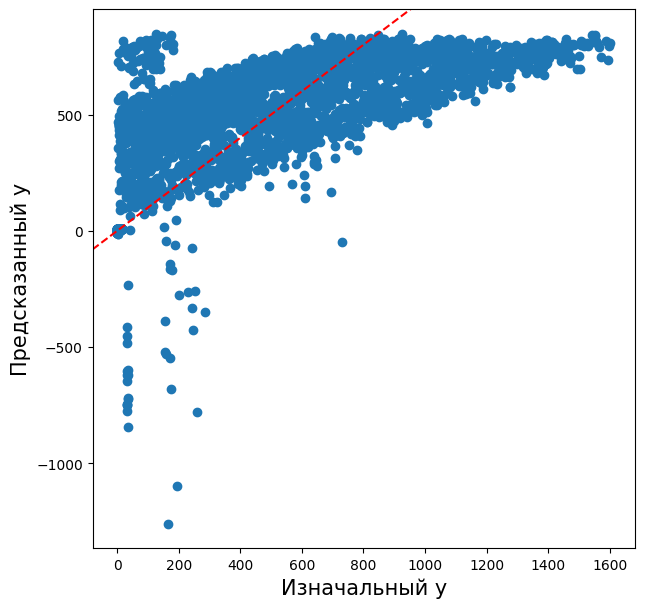

In [46]:
X_all_4_n = pd.read_csv('general_table_2_n.csv', delimiter=',')
y_all_4_n = pd.read_csv('general_table_target_2_n.csv', delimiter=',')
X_all_4_n = X_all_4_n.drop( 'Unnamed: 0', axis='columns')

X_2, y_2, r_2, mae_2,  mse_2 = lasso(X_all_4_n, y_all_4_n)
x_y(X_2,y_2)
lasso_r2.append(r_2)
lasso_mae.append(mae_2)
lasso_mse.append(mse_2)
print(r_2, mae_2, mse_2)

0.38427229208228675 118.06251211009288 42089.192082450696


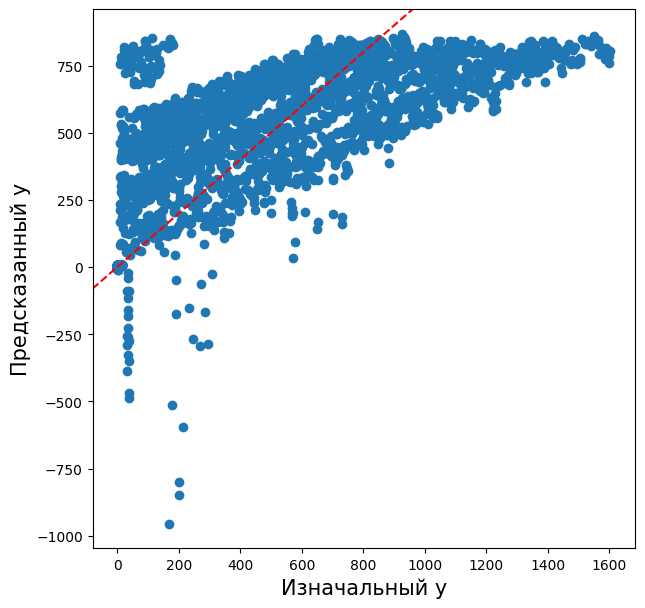

In [47]:
X_all_8_n = pd.read_csv('general_table_8_n.csv', delimiter=',')
y_all_8_n = pd.read_csv('general_table_target_8_n.csv', delimiter=',')
X_all_8_n = X_all_8_n.drop( 'Unnamed: 0', axis='columns')

X_3, y_3, r_3, mae_3, mse_3 = lasso(X_all_8_n, y_all_8_n)
lasso_r2.append(r_3)
lasso_mae.append(mae_3)
lasso_mse.append(mse_3)
x_y(X_3,y_3)
print(r_3, mae_3, mse_3)

0.4048036947286477 116.25412434972206 40467.37609675357


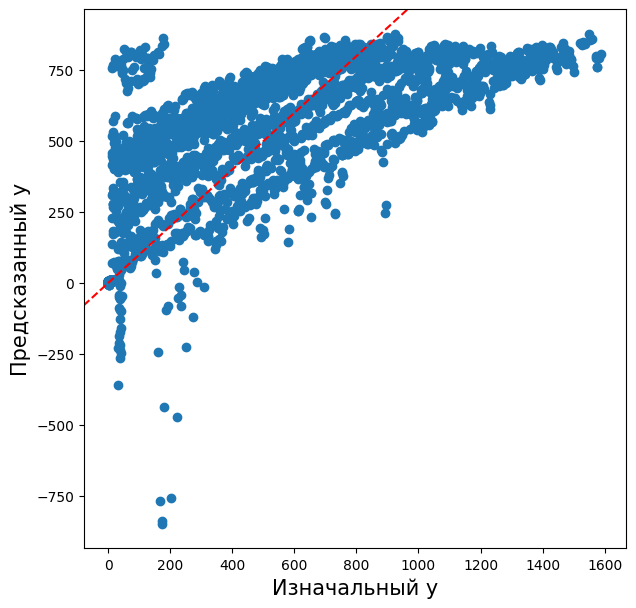

In [48]:
X_all_12_n = pd.read_csv('general_table_12_n.csv', delimiter=',')
y_all_12_n = pd.read_csv('general_table_target_12_n.csv', delimiter=',')
X_all_12_n = X_all_12_n.drop( 'Unnamed: 0', axis='columns')

X_4, y_4, r_4, mae_4, mse_4 = lasso(X_all_12_n, y_all_12_n)
lasso_r2.append(r_4)
lasso_mae.append(mae_4)
lasso_mse.append(mse_4)
x_y(X_4,y_4)
print(r_4, mae_4, mse_4)

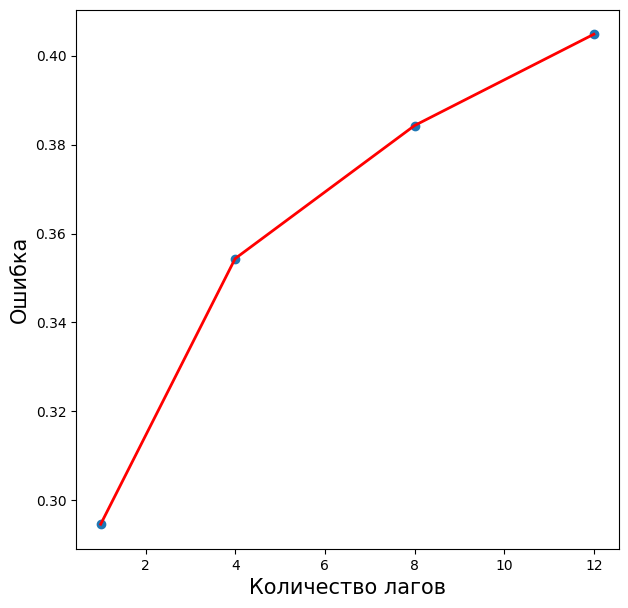

()

In [49]:
F_n( count_lag, lasso_r2)

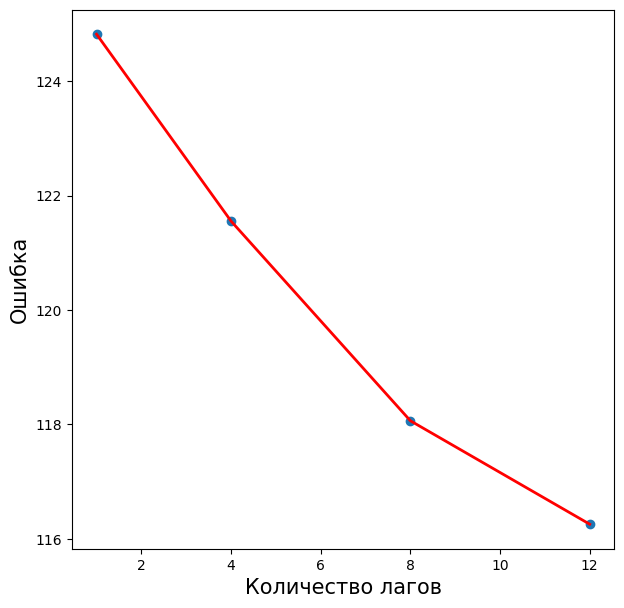

()

In [50]:
F_n(count_lag, lasso_mae)

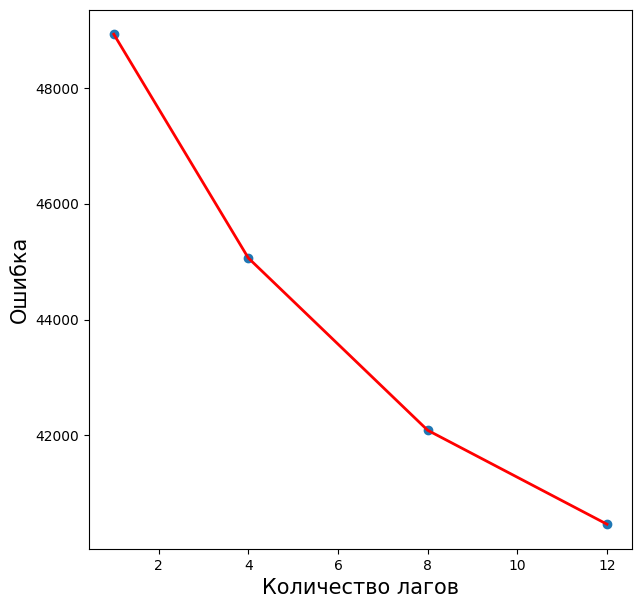

()

In [51]:
F_n(count_lag, lasso_mse)

XGBoost

In [52]:
def xgboost_(a, b):
    X_train, X_test, y_train, y_test = train_test_split(a,b, test_size = 0.2, random_state=42)
    xgb = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 2500)
    xgb.fit(X_train, y_train)
    test_predictions = xgb.predict(X_test)
    R2 = r2_score(y_test, test_predictions)
    mae_ = mae(y_test, test_predictions)
    mse_ = mse(y_test, test_predictions)
    return(y_test, test_predictions, R2, mae_, mse_)

0.4811360374480725 102.06691672742217 34551.481572163975


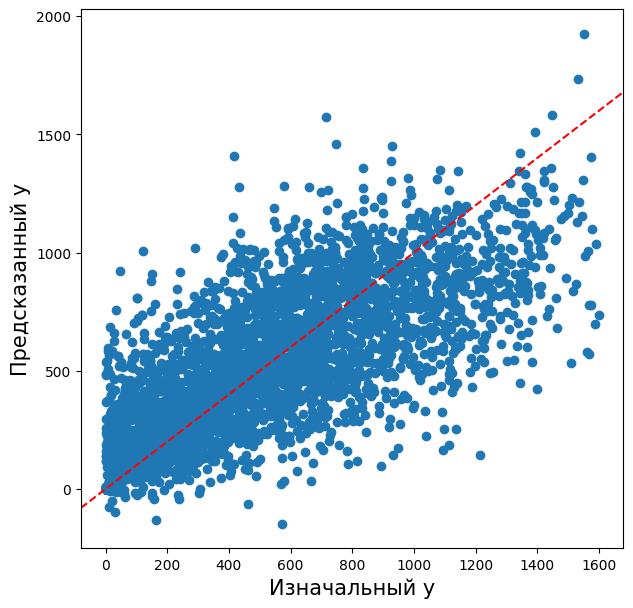

In [53]:
X_all_1_1 = pd.read_csv('general_table_1_1.csv', delimiter=',')
y_all_1_1 = pd.read_csv('general_table_target_1_1.csv', delimiter=',')
X_all_1_1 = X_all_1_1.drop( 'Unnamed: 0', axis='columns')

X, y, r_1, mae_1, mse_1 = xgboost_(X_all_1_1, y_all_1_1)
xgb_r2.append(r_1)
xgb_mae.append(mae_1)
xgb_mse.append(mse_1)
x_y(X,y)
print(r_1, mae_1, mse_1)

0.6461385574019889 85.09184635092518 25470.309137840584


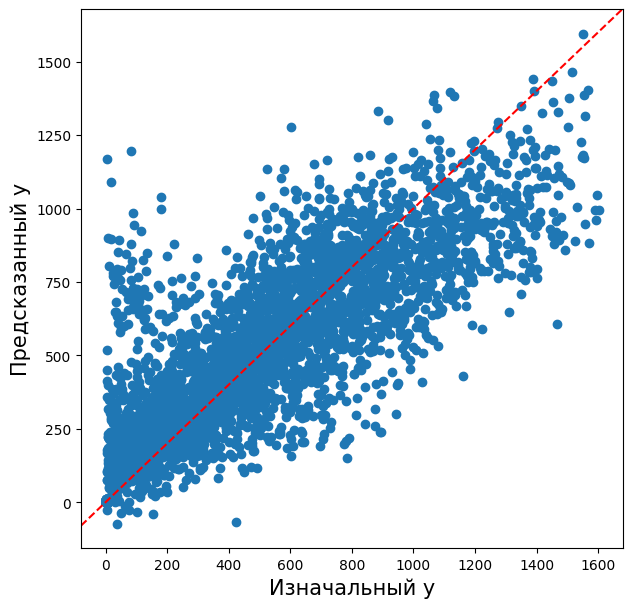

In [54]:
X_all_4_n = pd.read_csv('general_table_2_n.csv', delimiter=',')
y_all_4_n = pd.read_csv('general_table_target_2_n.csv', delimiter=',')
X_all_4_n = X_all_4_n.drop( 'Unnamed: 0', axis='columns')

X, y, r_2, mae_2, mse_2 = xgboost_(X_all_4_n, y_all_4_n)
xgb_r2.append(r_2)
xgb_mae.append(mae_2)
xgb_mse.append(mse_2)
x_y(X,y)
print(r_2, mae_2, mse_2)

0.6914525401726578 79.52753685947701 22050.844442981685


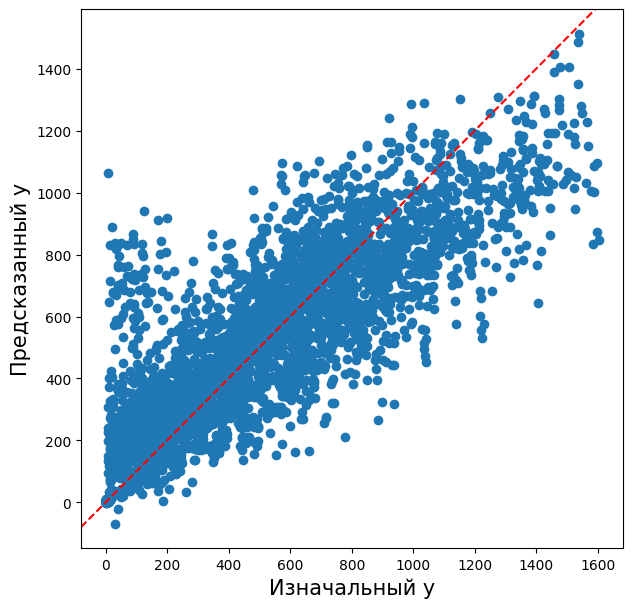

In [55]:
X_all_8_n = pd.read_csv('general_table_8_n.csv', delimiter=',')
y_all_8_n = pd.read_csv('general_table_target_8_n.csv', delimiter=',')
X_all_8_n = X_all_8_n.drop( 'Unnamed: 0', axis='columns')

X, y, r_3, mae_3, mse_3 = xgboost_(X_all_8_n, y_all_8_n)
xgb_r2.append(r_3)
xgb_mae.append(mae_3)
xgb_mse.append(mse_3)
x_y(X,y)
print(r_3, mae_3, mse_3)

0.7215493509270787 75.55991720421946 19509.341631471696


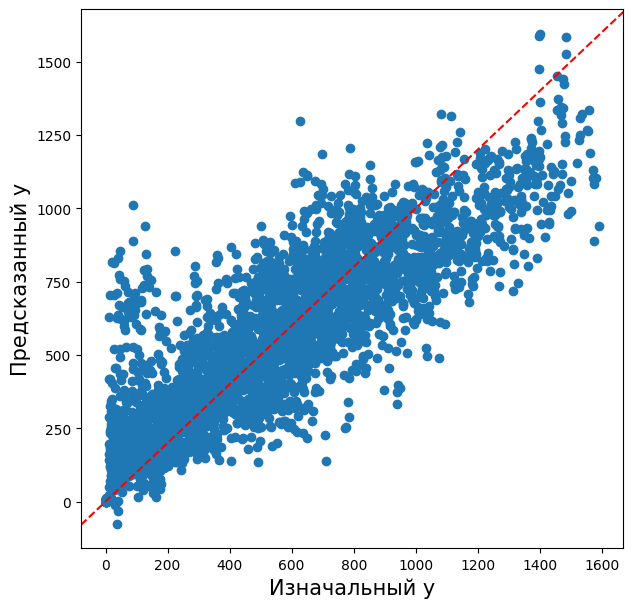

In [56]:
X_all_12_n = pd.read_csv('general_table_12_n.csv', delimiter=',')
y_all_12_n = pd.read_csv('general_table_target_12_n.csv', delimiter=',')
X_all_12_n = X_all_12_n.drop( 'Unnamed: 0', axis='columns')

X, y, r_4, mae_4, mse_4 = xgboost_(X_all_12_n, y_all_12_n)
xgb_r2.append(r_4)
xgb_mae.append(mae_4)
xgb_mse.append(mse_4)
x_y(X,y)
print(r_4, mae_4, mse_4)


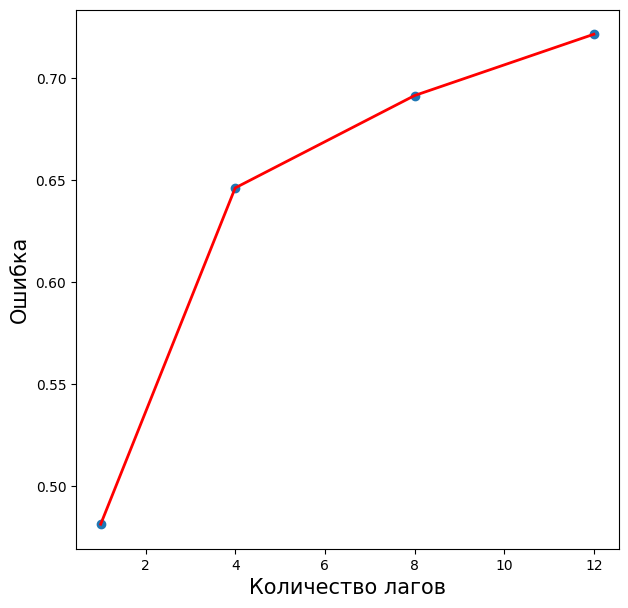

()

In [57]:
F_n(count_lag, xgb_r2,)

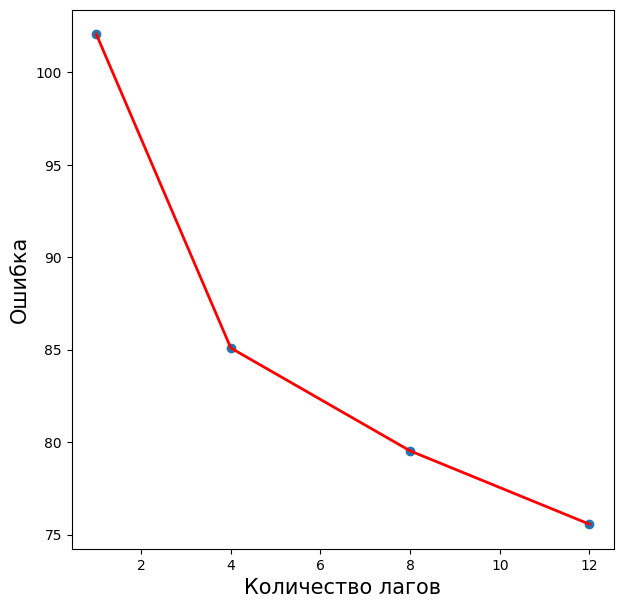

()

In [58]:
F_n(count_lag, xgb_mae)

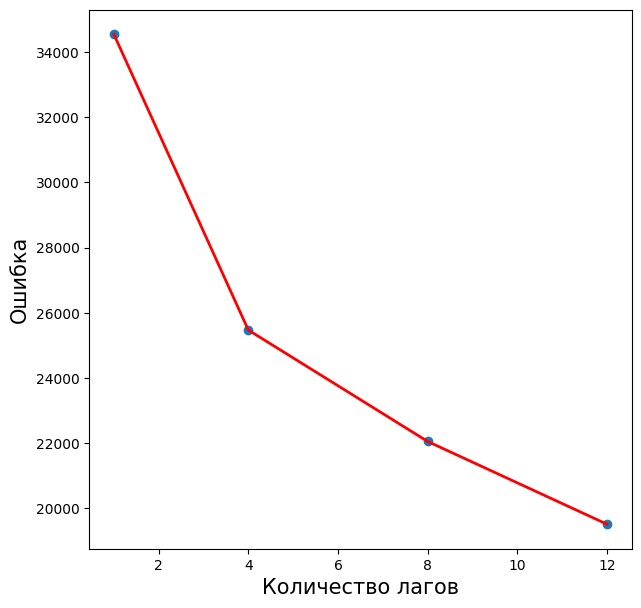

()

In [59]:
F_n(count_lag, xgb_mse)

Реализуем дополнительно для XGBoost кросс-валидацию

In [60]:
#реализация кросс-валидации для xgboost
def cross_valid_xg(general_table, general_table_target, eps=5):
    I = []
    for i in range(len(general_table_target)):
      I.append(i)
    l = len(I)
    i_cv = []
    epsln = []
    #заполняем i_cv
    k = int(l/eps)
    for i in range(eps):
        for j in range(k):
            i_cv.append(i)

    m = l - k * eps

    for i in range(m):
        i_cv.append(eps-1)

    i_cv = np.array(i_cv)

    np.random.shuffle(i_cv)

    #считаем epsln
    for cvi in range(eps):
        model = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 2500)
        model.fit(general_table.iloc[i_cv != cvi, :], general_table_target[i_cv != cvi])
        y_test = general_table_target[i_cv == cvi]
        y_pred = model.predict(general_table.iloc[i_cv == cvi, :])
        epsln.append(r2_score(y_test, y_pred))

    #считаем общее eps(all_eps)
    all_eps = 0
    for i in range(eps):
        all_eps += epsln[i]

    all_eps = all_eps / eps

    return (all_eps,y_test, y_pred)

0.4954503699099468

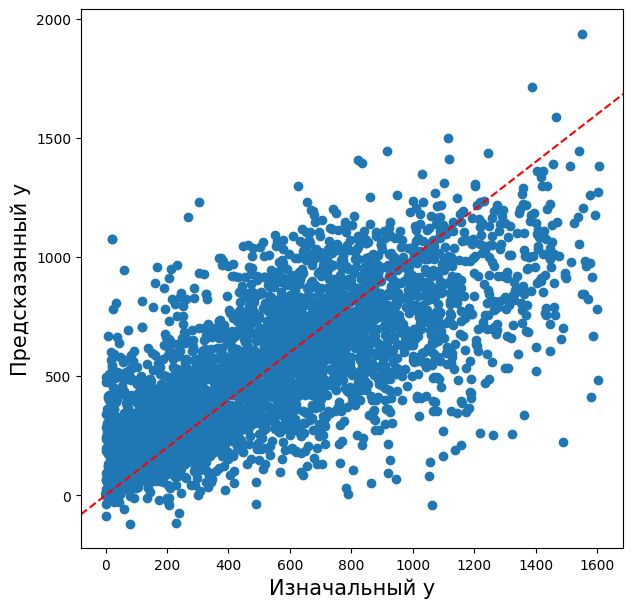

In [61]:
X_all_1_1 = pd.read_csv('general_table_1_1.csv', delimiter=',')
y_all_1_1 = pd.read_csv('general_table_target_1_1.csv', delimiter=',')
X_all_1_1 = X_all_1_1.drop( 'Unnamed: 0', axis='columns')

e, X, y = cross_valid_xg(X_all_1_1, y_all_1_1)
x_y(X,y)
xgb_c_v.append(e)
e

0.6655914583412266

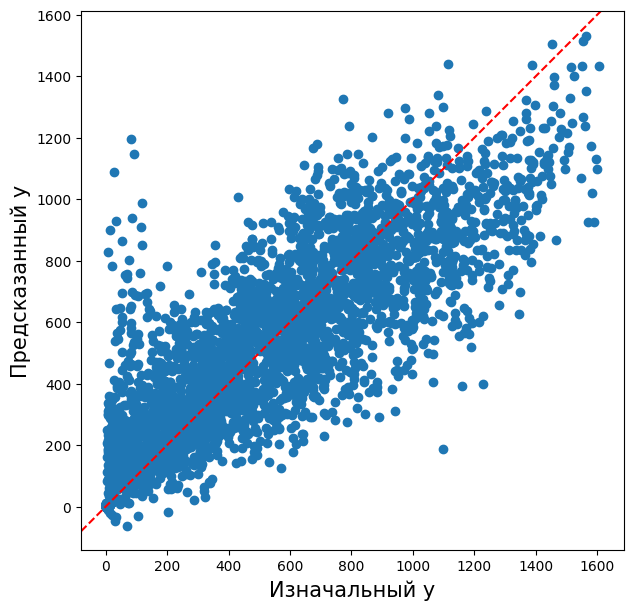

In [62]:
X_all_4_n = pd.read_csv('general_table_2_n.csv', delimiter=',')
y_all_4_n = pd.read_csv('general_table_target_2_n.csv', delimiter=',')
X_all_4_n = X_all_4_n.drop('Unnamed: 0', axis='columns')

e, X, y = cross_valid_xg(X_all_4_n, y_all_4_n)
x_y(X,y)
xgb_c_v.append(e)
e

0.7061730670951107

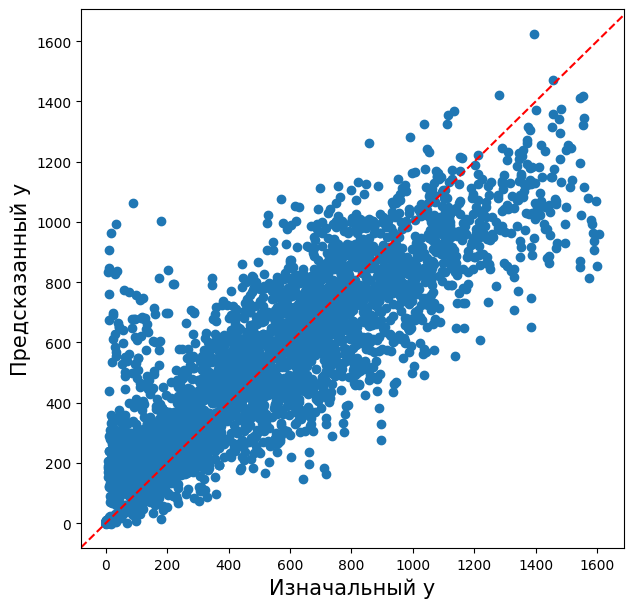

In [63]:
X_all_8_n = pd.read_csv('general_table_8_n.csv', delimiter=',')
y_all_8_n = pd.read_csv('general_table_target_8_n.csv', delimiter=',')
X_all_8_n = X_all_8_n.drop( 'Unnamed: 0', axis='columns')

e, X, y = cross_valid_xg(X_all_8_n, y_all_8_n)
x_y(X,y)
xgb_c_v.append(e)
e

0.7240643819098752

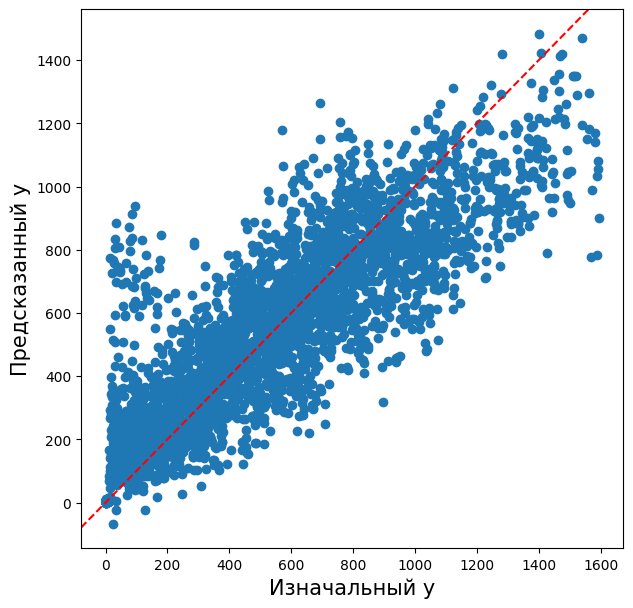

In [64]:
X_all_12_n = pd.read_csv('general_table_12_n.csv', delimiter=',')
y_all_12_n = pd.read_csv('general_table_target_12_n.csv', delimiter=',')
X_all_12_n = X_all_12_n.drop( 'Unnamed: 0', axis='columns')

e, X, y = cross_valid_xg(X_all_12_n, y_all_12_n)
x_y(X,y)
xgb_c_v.append(e)
e

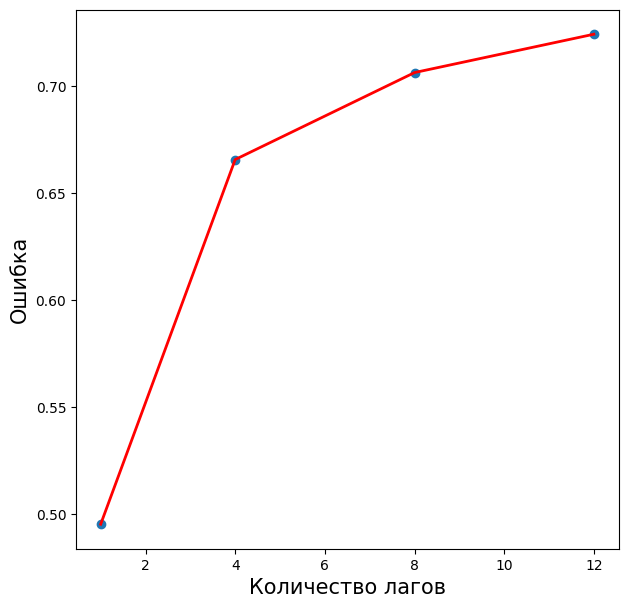

()

In [65]:
F_n(count_lag, xgb_c_v)